In [1]:
from lib_linear import *
import  time
import torch.nn.functional as F

input_input_matrix = np.array(pd.read_csv('input_input_matrix.csv'))
output_input_matrix = np.array(pd.read_csv('output_input_matrix.csv'))
output_output_matrix = np.array(pd.read_csv('output_output_matrix.csv'))

V_matrix = np.array(pd.read_csv('V_matrix.csv'))
U_matrix = np.array(pd.read_csv('U_matrix.csv'))
S31_matrix = np.array(pd.read_csv('S_matrix.csv'))  ##actually, just diag values

S11_matrix = V_matrix.T @ input_input_matrix @ V_matrix
S33_matrix = output_output_matrix

## Data

In [2]:
mean, std = calculate_mean_and_std()
train_data, test_data =  download_normalized_data(mean, std)

## Neural network model

In [3]:
class CustomNetwork(object):
    
    """
    Simple D-layer linear neural network 
    hidden_dims = topule(n0, n1, n2, ...nD)
    n0 = input layer
    n_D = output layer
    """
    
    def __init__(self, D, layers_dim):
        
        """
        Initialize network's weights according to Gaussian iid and network's biases with 0.0 values
        """
        
        self.weights = []
        
        self.D = len(layers_dim)-1
        assert self.D == D
        
        print("Depth of the network = number of hidden layers + 1:", D)
        
        for i in range(self.D):
            
            weight: torch.Tensor = torch.rand((layers_dim[i+1], layers_dim[i])) 
            
            stdv = 2/ np.sqrt(layers_dim[i])
            
            weight = (weight-0.5)*stdv

            weight.requires_grad = True
            
            self.weights.append(weight)
       
            
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network
        """

        for i in range(0,self.D):            
            x = torch.nn.functional.linear( input = x, weight=self.weights[i])
        return x 
    
    
    
    def parameters(self) -> List[torch.Tensor]:
        """
        Returns all trainable parameters 
        """
        return self.weights

In [4]:
input_dim = 784
output_dim = 10
hidden_dim1 = 100

D = 2

# initialize the model
model: CustomNetwork = CustomNetwork(D = D, layers_dim = (input_dim, hidden_dim1, output_dim))

Depth of the network = number of hidden layers + 1: 2


## Training parameters

In [5]:
# initialize the optimizer using the hyperparams below
lr: float = 0.005
momentum: float = 0.00
optimizer: torch.optim.Optimizer = SGD(params = model.parameters(), lr=lr)
criterion = nn.MSELoss() 
epoch: int = 3000

## Training loop

In [6]:
term_I_tab=[]
term_II_tab = []
term_IV_tab = []
MSE_tab = []
R_tab = []

In [7]:
batch_size: int = 1000 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

for e in range(epoch):
    for inner_counter, (x, y) in enumerate(train_loader):

        # reset the gradients from previouis iteration
        optimizer.zero_grad()

        # pass through the network
        output: torch.Tensor = model(x)  
        y=F.one_hot(y, num_classes=10).float()
        loss: torch.Tensor = criterion(output, y)

        # backward pass thorught the network
        loss.backward()

        # apply the gradients
        optimizer.step()     

    
    #add model parameters to tab
    loss_tab.append(loss.item())
    params_tab = []
    for param in model.parameters():
        params_tab.append(param.detach().numpy().flatten()  )

    w1_mean_tab.append(params_tab[0].mean())
    w2_mean_tab.append(params_tab[1].mean())
    w1_std_tab.append(params_tab[0].std())
    w2_std_tab.append(params_tab[1].std())


    # at the end of an epoch run evaluation on the test set
    with torch.no_grad():
        correct: int = 0 
        for i, (x, y) in enumerate(train_loader):
            # pass through the network            
            output: torch.Tensor = model(x)
            # update the number of correctly predicted examples
            pred_labels = torch.argmax(output, 1)
            correct += ( (pred_labels -y) ==0).sum()
        train_accuracy_tab.append( float(correct) / len(train_data))

        correct: int = 0 
        for i, (x, y) in enumerate(test_loader):
            # pass through the network            
            output: torch.Tensor = model(x)

            # update the number of correctly predicted examples
            pred_labels = torch.argmax(output, 1)
            correct += ( (pred_labels -y) ==0).sum()
        test_accuracy_tab.append( float(correct) / len(test_data))

    ########################################################################
    params=[]
    for param in model.parameters():
        params.append(param.detach().numpy())
    w1=params[0] 
    w2=params[1]

    R = U_matrix.T @ w2 @ w1 @ V_matrix

    term_1 = 0
    for alpha in range(10):
        term_1 += (R[alpha][alpha] - S31_matrix[alpha]/S11_matrix[alpha][alpha])**2 * S11_matrix[alpha][alpha]

    term_2 = 0
    for beta in range(10):
        for alpha in range(784):
            if(alpha != beta):
                term_2 += (R[beta][alpha])**2 *S11_matrix[alpha][alpha]

    term_4 = 0
    for alpha in range(10):
        term_4+= (R[alpha][alpha])**2*S11_matrix[alpha][alpha]
    
    term_I_tab.append(term_1)
    term_II_tab.append(term_2)
    term_IV_tab.append(term_4)
    R_tab.append(R)

    term_1 = round(float(term_1), 6)
    term_2 = round(term_2, 6)

    check = round(1+ term_2 - term_4, 6)
    check2 = round(1+ term_1 + term_2 - term_4, 6)

    print(f"{e}\t{loss} \t term1: {term_1}, \t term2: {term_2} \t {check}\t {check2}")   



0	0.1055949479341507 	 term1: 0.148209, 	 term2: 0.403429 	 1.199191	 1.3474
1	0.08576971292495728 	 term1: 0.074368, 	 term2: 0.310781 	 1.018296	 1.092664
2	0.07534927129745483 	 term1: 0.041336, 	 term2: 0.260719 	 0.904991	 0.946327
3	0.0688185766339302 	 term1: 0.024369, 	 term2: 0.229373 	 0.827061	 0.85143
4	0.06428621709346771 	 term1: 0.014941, 	 term2: 0.208163 	 0.770252	 0.785193
5	0.060935694724321365 	 term1: 0.009514, 	 term2: 0.193092 	 0.726923	 0.736437
6	0.05834972485899925 	 term1: 0.006389, 	 term2: 0.182001 	 0.692708	 0.699097
7	0.056289225816726685 	 term1: 0.004656, 	 term2: 0.173616 	 0.664965	 0.669621
8	0.05460600554943085 	 term1: 0.003792, 	 term2: 0.167138 	 0.642012	 0.645804
9	0.053202953189611435 	 term1: 0.003479, 	 term2: 0.162042 	 0.622718	 0.626197
10	0.05201368406414986 	 term1: 0.003518, 	 term2: 0.157973 	 0.60629	 0.609808
11	0.05099126324057579 	 term1: 0.003782, 	 term2: 0.15468 	 0.592149	 0.595931
12	0.05010156333446503 	 term1: 0.004188, 

102	0.03779059275984764 	 term1: 0.026003, 	 term2: 0.137146 	 0.424108	 0.450111
103	0.03776203840970993 	 term1: 0.026095, 	 term2: 0.137196 	 0.42378	 0.449875
104	0.03773391991853714 	 term1: 0.026186, 	 term2: 0.137246 	 0.423456	 0.449642
105	0.03770621493458748 	 term1: 0.026277, 	 term2: 0.137297 	 0.423139	 0.449416
106	0.03767891973257065 	 term1: 0.026366, 	 term2: 0.137347 	 0.422824	 0.44919
107	0.037652019411325455 	 term1: 0.026454, 	 term2: 0.137399 	 0.422517	 0.448971
108	0.0376255176961422 	 term1: 0.026542, 	 term2: 0.13745 	 0.422212	 0.448754
109	0.03759939223527908 	 term1: 0.026628, 	 term2: 0.137501 	 0.421912	 0.44854
110	0.037573639303445816 	 term1: 0.026714, 	 term2: 0.137553 	 0.421617	 0.448331
111	0.0375482514500618 	 term1: 0.026798, 	 term2: 0.137605 	 0.421326	 0.448124
112	0.03752321004867554 	 term1: 0.026882, 	 term2: 0.137657 	 0.42104	 0.447922
113	0.03749853000044823 	 term1: 0.026965, 	 term2: 0.137709 	 0.420757	 0.447722
114	0.037474177777767

203	0.03611871972680092 	 term1: 0.032208, 	 term2: 0.142385 	 0.405255	 0.437463
204	0.03610900044441223 	 term1: 0.03225, 	 term2: 0.142433 	 0.405148	 0.437398
205	0.03609936311841011 	 term1: 0.032292, 	 term2: 0.142481 	 0.405043	 0.437335
206	0.03608979657292366 	 term1: 0.032333, 	 term2: 0.142529 	 0.404939	 0.437272
207	0.03608030080795288 	 term1: 0.032374, 	 term2: 0.142576 	 0.404835	 0.437209
208	0.03607087582349777 	 term1: 0.032415, 	 term2: 0.142623 	 0.404732	 0.437147
209	0.036061521619558334 	 term1: 0.032456, 	 term2: 0.142671 	 0.40463	 0.437086
210	0.036052245646715164 	 term1: 0.032496, 	 term2: 0.142718 	 0.404529	 0.437025
211	0.036043036729097366 	 term1: 0.032537, 	 term2: 0.142765 	 0.404429	 0.436966
212	0.03603389114141464 	 term1: 0.032576, 	 term2: 0.142812 	 0.404329	 0.436905
213	0.03602482005953789 	 term1: 0.032616, 	 term2: 0.142859 	 0.404231	 0.436847
214	0.036015816032886505 	 term1: 0.032656, 	 term2: 0.142905 	 0.404132	 0.436788
215	0.03600687

304	0.03540681675076485 	 term1: 0.035494, 	 term2: 0.146608 	 0.397658	 0.433152
305	0.03540170192718506 	 term1: 0.035519, 	 term2: 0.146644 	 0.397605	 0.433124
306	0.03539661690592766 	 term1: 0.035544, 	 term2: 0.14668 	 0.397552	 0.433096
307	0.03539155423641205 	 term1: 0.035569, 	 term2: 0.146715 	 0.397499	 0.433068
308	0.03538651019334793 	 term1: 0.035594, 	 term2: 0.146751 	 0.397447	 0.433041
309	0.0353814996778965 	 term1: 0.035619, 	 term2: 0.146787 	 0.397396	 0.433015
310	0.03537651151418686 	 term1: 0.035644, 	 term2: 0.146822 	 0.397344	 0.432988
311	0.035371553152799606 	 term1: 0.035668, 	 term2: 0.146858 	 0.397294	 0.432962
312	0.03536662086844444 	 term1: 0.035693, 	 term2: 0.146893 	 0.397243	 0.432936
313	0.03536171093583107 	 term1: 0.035717, 	 term2: 0.146928 	 0.397192	 0.432909
314	0.035356830805540085 	 term1: 0.035741, 	 term2: 0.146963 	 0.397141	 0.432882
315	0.03535197302699089 	 term1: 0.035766, 	 term2: 0.146998 	 0.397091	 0.432857
316	0.0353471376

405	0.03499666973948479 	 term1: 0.037594, 	 term2: 0.149775 	 0.393514	 0.431108
406	0.03499345853924751 	 term1: 0.037611, 	 term2: 0.149802 	 0.393482	 0.431093
407	0.03499025106430054 	 term1: 0.037628, 	 term2: 0.149829 	 0.393451	 0.431079
408	0.034987062215805054 	 term1: 0.037645, 	 term2: 0.149856 	 0.393419	 0.431064
409	0.03498389199376106 	 term1: 0.037662, 	 term2: 0.149883 	 0.393388	 0.43105
410	0.03498072549700737 	 term1: 0.037679, 	 term2: 0.14991 	 0.393357	 0.431036
411	0.03497757390141487 	 term1: 0.037695, 	 term2: 0.149937 	 0.393327	 0.431022
412	0.034974437206983566 	 term1: 0.037712, 	 term2: 0.149963 	 0.393295	 0.431007
413	0.03497131168842316 	 term1: 0.037729, 	 term2: 0.14999 	 0.393265	 0.430994
414	0.034968193620443344 	 term1: 0.037745, 	 term2: 0.150016 	 0.393234	 0.430979
415	0.03496510162949562 	 term1: 0.037762, 	 term2: 0.150043 	 0.393204	 0.430966
416	0.034962013363838196 	 term1: 0.037778, 	 term2: 0.150069 	 0.393173	 0.430951
417	0.034958936

506	0.034726615995168686 	 term1: 0.03906, 	 term2: 0.152188 	 0.390908	 0.429968
507	0.0347244031727314 	 term1: 0.039073, 	 term2: 0.152209 	 0.390887	 0.42996
508	0.03472219407558441 	 term1: 0.039085, 	 term2: 0.15223 	 0.390866	 0.429951
509	0.03471999242901802 	 term1: 0.039097, 	 term2: 0.152251 	 0.390846	 0.429943
510	0.034717801958322525 	 term1: 0.039109, 	 term2: 0.152271 	 0.390824	 0.429933
511	0.03471561148762703 	 term1: 0.039122, 	 term2: 0.152292 	 0.390804	 0.429926
512	0.03471343591809273 	 term1: 0.039134, 	 term2: 0.152313 	 0.390783	 0.429917
513	0.034711260348558426 	 term1: 0.039146, 	 term2: 0.152333 	 0.390762	 0.429908
514	0.03470909595489502 	 term1: 0.039158, 	 term2: 0.152354 	 0.390742	 0.4299
515	0.03470693901181221 	 term1: 0.03917, 	 term2: 0.152375 	 0.390722	 0.429892
516	0.0347047857940197 	 term1: 0.039182, 	 term2: 0.152395 	 0.390702	 0.429884
517	0.03470264747738838 	 term1: 0.039194, 	 term2: 0.152416 	 0.390682	 0.429876
518	0.034700505435466

607	0.03453502804040909 	 term1: 0.040143, 	 term2: 0.154072 	 0.389123	 0.429266
608	0.034533414989709854 	 term1: 0.040152, 	 term2: 0.154088 	 0.389108	 0.42926
609	0.03453180193901062 	 term1: 0.040161, 	 term2: 0.154105 	 0.389093	 0.429254
610	0.034530192613601685 	 term1: 0.040171, 	 term2: 0.154121 	 0.389078	 0.429249
611	0.03452858701348305 	 term1: 0.04018, 	 term2: 0.154138 	 0.389064	 0.429244
612	0.03452698513865471 	 term1: 0.040189, 	 term2: 0.154154 	 0.389049	 0.429238
613	0.034525394439697266 	 term1: 0.040198, 	 term2: 0.15417 	 0.389034	 0.429232
614	0.03452380374073982 	 term1: 0.040207, 	 term2: 0.154187 	 0.38902	 0.429227
615	0.034522220492362976 	 term1: 0.040217, 	 term2: 0.154203 	 0.389005	 0.429222
616	0.03452063724398613 	 term1: 0.040226, 	 term2: 0.154219 	 0.38899	 0.429216
617	0.03451906144618988 	 term1: 0.040235, 	 term2: 0.154235 	 0.388976	 0.429211
618	0.03451748937368393 	 term1: 0.040244, 	 term2: 0.154252 	 0.388962	 0.429206
619	0.03451592475

707	0.034393616020679474 	 term1: 0.040967, 	 term2: 0.155563 	 0.387837	 0.428804
708	0.03439238294959068 	 term1: 0.040974, 	 term2: 0.155576 	 0.387826	 0.4288
709	0.03439115360379219 	 term1: 0.040981, 	 term2: 0.15559 	 0.387815	 0.428796
710	0.034389927983284 	 term1: 0.040989, 	 term2: 0.155603 	 0.387804	 0.428793
711	0.0343887060880661 	 term1: 0.040996, 	 term2: 0.155616 	 0.387793	 0.428789
712	0.034387484192848206 	 term1: 0.041003, 	 term2: 0.15563 	 0.387782	 0.428785
713	0.034386273473501205 	 term1: 0.04101, 	 term2: 0.155643 	 0.387771	 0.428781
714	0.03438505530357361 	 term1: 0.041018, 	 term2: 0.155656 	 0.38776	 0.428778
715	0.03438384830951691 	 term1: 0.041025, 	 term2: 0.155669 	 0.387749	 0.428774
716	0.034382641315460205 	 term1: 0.041032, 	 term2: 0.155683 	 0.387739	 0.428771
717	0.0343814380466938 	 term1: 0.041039, 	 term2: 0.155696 	 0.387728	 0.428767
718	0.0343802385032177 	 term1: 0.041046, 	 term2: 0.155709 	 0.387717	 0.428763
719	0.03437903895974159

808	0.03428342565894127 	 term1: 0.041627, 	 term2: 0.156792 	 0.386852	 0.428479
809	0.034282464534044266 	 term1: 0.041633, 	 term2: 0.156803 	 0.386843	 0.428476
810	0.034281499683856964 	 term1: 0.041638, 	 term2: 0.156814 	 0.386835	 0.428473
811	0.03428053855895996 	 term1: 0.041644, 	 term2: 0.156825 	 0.386826	 0.42847
812	0.03427958860993385 	 term1: 0.04165, 	 term2: 0.156836 	 0.386818	 0.428468
813	0.03427862748503685 	 term1: 0.041656, 	 term2: 0.156847 	 0.386809	 0.428465
814	0.03427768126130104 	 term1: 0.041662, 	 term2: 0.156858 	 0.386801	 0.428463
815	0.034276727586984634 	 term1: 0.041667, 	 term2: 0.156869 	 0.386793	 0.42846
816	0.034275781363248825 	 term1: 0.041673, 	 term2: 0.15688 	 0.386785	 0.428458
817	0.03427483141422272 	 term1: 0.041679, 	 term2: 0.156891 	 0.386776	 0.428455
818	0.034273892641067505 	 term1: 0.041685, 	 term2: 0.156902 	 0.386768	 0.428453
819	0.034272946417331696 	 term1: 0.04169, 	 term2: 0.156912 	 0.386759	 0.428449
820	0.034272007

909	0.03419627249240875 	 term1: 0.042162, 	 term2: 0.157813 	 0.386082	 0.428244
910	0.03419549763202667 	 term1: 0.042167, 	 term2: 0.157822 	 0.386075	 0.428242
911	0.03419473394751549 	 term1: 0.042171, 	 term2: 0.157831 	 0.386068	 0.428239
912	0.034193962812423706 	 term1: 0.042176, 	 term2: 0.15784 	 0.386061	 0.428237
913	0.03419319912791252 	 term1: 0.042181, 	 term2: 0.157849 	 0.386054	 0.428235
914	0.03419243544340134 	 term1: 0.042186, 	 term2: 0.157858 	 0.386047	 0.428233
915	0.03419167175889015 	 term1: 0.042191, 	 term2: 0.157868 	 0.386041	 0.428232
916	0.03419090807437897 	 term1: 0.042195, 	 term2: 0.157877 	 0.386034	 0.428229
917	0.03419015184044838 	 term1: 0.0422, 	 term2: 0.157886 	 0.386028	 0.428228
918	0.034189388155937195 	 term1: 0.042205, 	 term2: 0.157895 	 0.386021	 0.428226
919	0.03418863192200661 	 term1: 0.042209, 	 term2: 0.157904 	 0.386014	 0.428223
920	0.034187883138656616 	 term1: 0.042214, 	 term2: 0.157913 	 0.386007	 0.428221
921	0.0341871231

1010	0.03412586450576782 	 term1: 0.042605, 	 term2: 0.158673 	 0.385463	 0.428068
1011	0.034125231206417084 	 term1: 0.042609, 	 term2: 0.158681 	 0.385457	 0.428066
1012	0.034124601632356644 	 term1: 0.042613, 	 term2: 0.158688 	 0.385451	 0.428064
1013	0.0341239795088768 	 term1: 0.042617, 	 term2: 0.158696 	 0.385446	 0.428063
1014	0.03412335366010666 	 term1: 0.042621, 	 term2: 0.158704 	 0.38544	 0.428061
1015	0.034122735261917114 	 term1: 0.042625, 	 term2: 0.158712 	 0.385435	 0.42806
1016	0.034122105687856674 	 term1: 0.042629, 	 term2: 0.15872 	 0.38543	 0.428059
1017	0.03412148728966713 	 term1: 0.042633, 	 term2: 0.158727 	 0.385423	 0.428056
1018	0.034120868891477585 	 term1: 0.042637, 	 term2: 0.158735 	 0.385418	 0.428055
1019	0.03412024676799774 	 term1: 0.042641, 	 term2: 0.158743 	 0.385413	 0.428054
1020	0.0341196283698082 	 term1: 0.042645, 	 term2: 0.158751 	 0.385408	 0.428053
1021	0.03411901369690895 	 term1: 0.042649, 	 term2: 0.158758 	 0.385402	 0.428051
1022	

1110	0.0340685173869133 	 term1: 0.042974, 	 term2: 0.159401 	 0.384959	 0.427933
1111	0.034067995846271515 	 term1: 0.042978, 	 term2: 0.159407 	 0.384954	 0.427932
1112	0.03406747430562973 	 term1: 0.042981, 	 term2: 0.159414 	 0.38495	 0.427931
1113	0.034066956490278244 	 term1: 0.042985, 	 term2: 0.159421 	 0.384945	 0.42793
1114	0.03406643494963646 	 term1: 0.042988, 	 term2: 0.159428 	 0.384941	 0.427929
1115	0.034065913408994675 	 term1: 0.042991, 	 term2: 0.159434 	 0.384936	 0.427927
1116	0.03406539931893349 	 term1: 0.042995, 	 term2: 0.159441 	 0.384932	 0.427927
1117	0.0340648852288723 	 term1: 0.042998, 	 term2: 0.159448 	 0.384927	 0.427925
1118	0.03406436741352081 	 term1: 0.043001, 	 term2: 0.159454 	 0.384922	 0.427923
1119	0.03406384959816933 	 term1: 0.043005, 	 term2: 0.159461 	 0.384918	 0.427923
1120	0.03406333550810814 	 term1: 0.043008, 	 term2: 0.159468 	 0.384914	 0.427922
1121	0.03406282886862755 	 term1: 0.043012, 	 term2: 0.159474 	 0.384909	 0.427921
1122	

1209	0.0340210385620594 	 term1: 0.043287, 	 term2: 0.160025 	 0.384542	 0.427829
1210	0.034020595252513885 	 term1: 0.04329, 	 term2: 0.160031 	 0.384538	 0.427828
1211	0.034020159393548965 	 term1: 0.043293, 	 term2: 0.160037 	 0.384535	 0.427828
1212	0.03401971980929375 	 term1: 0.043296, 	 term2: 0.160043 	 0.384531	 0.427827
1213	0.03401928022503853 	 term1: 0.043299, 	 term2: 0.160048 	 0.384526	 0.427825
1214	0.03401884436607361 	 term1: 0.043302, 	 term2: 0.160054 	 0.384522	 0.427824
1215	0.03401841223239899 	 term1: 0.043305, 	 term2: 0.16006 	 0.384519	 0.427824
1216	0.03401797637343407 	 term1: 0.043308, 	 term2: 0.160066 	 0.384515	 0.427823
1217	0.03401754051446915 	 term1: 0.043311, 	 term2: 0.160072 	 0.384512	 0.427823
1218	0.034017108380794525 	 term1: 0.043313, 	 term2: 0.160078 	 0.384508	 0.427821
1219	0.034016676247119904 	 term1: 0.043316, 	 term2: 0.160083 	 0.384503	 0.427819
1220	0.034016236662864685 	 term1: 0.043319, 	 term2: 0.160089 	 0.3845	 0.427819
1221

1308	0.03398081660270691 	 term1: 0.043558, 	 term2: 0.160571 	 0.384188	 0.427746
1309	0.033980436623096466 	 term1: 0.043561, 	 term2: 0.160576 	 0.384184	 0.427745
1310	0.03398006409406662 	 term1: 0.043563, 	 term2: 0.160582 	 0.384182	 0.427745
1311	0.03397969529032707 	 term1: 0.043566, 	 term2: 0.160587 	 0.384178	 0.427744
1312	0.033979322761297226 	 term1: 0.043568, 	 term2: 0.160592 	 0.384175	 0.427743
1313	0.03397894650697708 	 term1: 0.043571, 	 term2: 0.160597 	 0.384171	 0.427742
1314	0.033978573977947235 	 term1: 0.043573, 	 term2: 0.160602 	 0.384168	 0.427741
1315	0.03397820517420769 	 term1: 0.043576, 	 term2: 0.160607 	 0.384165	 0.427741
1316	0.03397783264517784 	 term1: 0.043578, 	 term2: 0.160612 	 0.384161	 0.427739
1317	0.03397746756672859 	 term1: 0.043581, 	 term2: 0.160618 	 0.384159	 0.42774
1318	0.03397709131240845 	 term1: 0.043584, 	 term2: 0.160623 	 0.384155	 0.427739
1319	0.0339767225086689 	 term1: 0.043586, 	 term2: 0.160628 	 0.384152	 0.427738
132

1407	0.03394636511802673 	 term1: 0.043795, 	 term2: 0.161053 	 0.383883	 0.427678
1408	0.03394604101777077 	 term1: 0.043797, 	 term2: 0.161058 	 0.38388	 0.427677
1409	0.0339457206428051 	 term1: 0.0438, 	 term2: 0.161063 	 0.383878	 0.427678
1410	0.03394539654254913 	 term1: 0.043802, 	 term2: 0.161067 	 0.383875	 0.427677
1411	0.033945076167583466 	 term1: 0.043804, 	 term2: 0.161072 	 0.383872	 0.427676
1412	0.0339447557926178 	 term1: 0.043806, 	 term2: 0.161076 	 0.383869	 0.427675
1413	0.03394443914294243 	 term1: 0.043809, 	 term2: 0.161081 	 0.383866	 0.427675
1414	0.03394411504268646 	 term1: 0.043811, 	 term2: 0.161085 	 0.383863	 0.427674
1415	0.03394379839301109 	 term1: 0.043813, 	 term2: 0.16109 	 0.383861	 0.427674
1416	0.033943481743335724 	 term1: 0.043815, 	 term2: 0.161094 	 0.383857	 0.427672
1417	0.033943161368370056 	 term1: 0.043818, 	 term2: 0.161099 	 0.383855	 0.427673
1418	0.03394284099340439 	 term1: 0.04382, 	 term2: 0.161103 	 0.383851	 0.427671
1419	0.0

1506	0.03391660004854202 	 term1: 0.044004, 	 term2: 0.161482 	 0.383618	 0.427622
1507	0.03391631692647934 	 term1: 0.044006, 	 term2: 0.161486 	 0.383616	 0.427622
1508	0.033916037529706955 	 term1: 0.044008, 	 term2: 0.16149 	 0.383613	 0.427621
1509	0.03391575440764427 	 term1: 0.04401, 	 term2: 0.161494 	 0.38361	 0.42762
1510	0.033915478736162186 	 term1: 0.044012, 	 term2: 0.161498 	 0.383608	 0.42762
1511	0.0339151993393898 	 term1: 0.044014, 	 term2: 0.161503 	 0.383606	 0.42762
1512	0.033914923667907715 	 term1: 0.044016, 	 term2: 0.161507 	 0.383604	 0.42762
1513	0.03391464427113533 	 term1: 0.044018, 	 term2: 0.161511 	 0.383601	 0.427619
1514	0.033914364874362946 	 term1: 0.04402, 	 term2: 0.161515 	 0.383599	 0.427619
1515	0.03391408920288086 	 term1: 0.044022, 	 term2: 0.161519 	 0.383596	 0.427618
1516	0.03391381353139877 	 term1: 0.044024, 	 term2: 0.161523 	 0.383594	 0.427618
1517	0.033913541585206985 	 term1: 0.044026, 	 term2: 0.161527 	 0.383591	 0.427617
1518	0.0

1605	0.03389064595103264 	 term1: 0.04419, 	 term2: 0.161866 	 0.383386	 0.427576
1606	0.03389040380716324 	 term1: 0.044192, 	 term2: 0.16187 	 0.383384	 0.427576
1607	0.03389015421271324 	 term1: 0.044194, 	 term2: 0.161873 	 0.383381	 0.427575
1608	0.03388991579413414 	 term1: 0.044196, 	 term2: 0.161877 	 0.38338	 0.427576
1609	0.03388966992497444 	 term1: 0.044198, 	 term2: 0.161881 	 0.383378	 0.427576
1610	0.03388942405581474 	 term1: 0.044199, 	 term2: 0.161884 	 0.383375	 0.427574
1611	0.033889178186655045 	 term1: 0.044201, 	 term2: 0.161888 	 0.383373	 0.427574
1612	0.03388893976807594 	 term1: 0.044203, 	 term2: 0.161892 	 0.383371	 0.427574
1613	0.03388869762420654 	 term1: 0.044205, 	 term2: 0.161895 	 0.383368	 0.427573
1614	0.033888451755046844 	 term1: 0.044206, 	 term2: 0.161899 	 0.383367	 0.427573
1615	0.033888209611177444 	 term1: 0.044208, 	 term2: 0.161903 	 0.383365	 0.427573
1616	0.033887967467308044 	 term1: 0.04421, 	 term2: 0.161906 	 0.383362	 0.427572
1617

1705	0.03386765345931053 	 term1: 0.044359, 	 term2: 0.162215 	 0.383178	 0.427537
1706	0.03386744111776352 	 term1: 0.04436, 	 term2: 0.162218 	 0.383176	 0.427536
1707	0.03386722505092621 	 term1: 0.044362, 	 term2: 0.162222 	 0.383175	 0.427537
1708	0.0338670089840889 	 term1: 0.044364, 	 term2: 0.162225 	 0.383173	 0.427537
1709	0.033866796642541885 	 term1: 0.044365, 	 term2: 0.162228 	 0.38317	 0.427535
1710	0.03386658430099487 	 term1: 0.044367, 	 term2: 0.162232 	 0.383169	 0.427536
1711	0.03386636823415756 	 term1: 0.044368, 	 term2: 0.162235 	 0.383167	 0.427535
1712	0.03386615216732025 	 term1: 0.04437, 	 term2: 0.162238 	 0.383165	 0.427535
1713	0.03386593982577324 	 term1: 0.044371, 	 term2: 0.162242 	 0.383163	 0.427534
1714	0.03386572748422623 	 term1: 0.044373, 	 term2: 0.162245 	 0.383161	 0.427534
1715	0.033865511417388916 	 term1: 0.044375, 	 term2: 0.162248 	 0.383159	 0.427534
1716	0.033865299075841904 	 term1: 0.044376, 	 term2: 0.162251 	 0.383157	 0.427533
1717	

1804	0.033847562968730927 	 term1: 0.044509, 	 term2: 0.162528 	 0.382996	 0.427505
1805	0.03384736552834511 	 term1: 0.04451, 	 term2: 0.162531 	 0.382994	 0.427504
1806	0.033847179263830185 	 term1: 0.044512, 	 term2: 0.162534 	 0.382992	 0.427504
1807	0.03384698927402496 	 term1: 0.044513, 	 term2: 0.162537 	 0.38299	 0.427503
1808	0.03384679555892944 	 term1: 0.044515, 	 term2: 0.16254 	 0.382989	 0.427504
1809	0.03384660556912422 	 term1: 0.044516, 	 term2: 0.162543 	 0.382987	 0.427503
1810	0.033846415579319 	 term1: 0.044517, 	 term2: 0.162546 	 0.382985	 0.427502
1811	0.03384622931480408 	 term1: 0.044519, 	 term2: 0.162549 	 0.382983	 0.427502
1812	0.03384603559970856 	 term1: 0.04452, 	 term2: 0.162552 	 0.382982	 0.427502
1813	0.033845845609903336 	 term1: 0.044522, 	 term2: 0.162555 	 0.38298	 0.427502
1814	0.03384565934538841 	 term1: 0.044523, 	 term2: 0.162558 	 0.382978	 0.427501
1815	0.03384546935558319 	 term1: 0.044525, 	 term2: 0.162561 	 0.382977	 0.427502
1816	0.0

1904	0.03382951766252518 	 term1: 0.044646, 	 term2: 0.162816 	 0.382831	 0.427477
1905	0.033829350024461746 	 term1: 0.044647, 	 term2: 0.162818 	 0.382828	 0.427475
1906	0.03382917866110802 	 term1: 0.044649, 	 term2: 0.162821 	 0.382827	 0.427476
1907	0.03382900729775429 	 term1: 0.04465, 	 term2: 0.162824 	 0.382826	 0.427476
1908	0.03382883593440056 	 term1: 0.044651, 	 term2: 0.162827 	 0.382824	 0.427475
1909	0.033828672021627426 	 term1: 0.044652, 	 term2: 0.162829 	 0.382822	 0.427474
1910	0.0338285006582737 	 term1: 0.044654, 	 term2: 0.162832 	 0.382821	 0.427475
1911	0.03382832929491997 	 term1: 0.044655, 	 term2: 0.162835 	 0.382819	 0.427474
1912	0.03382816165685654 	 term1: 0.044656, 	 term2: 0.162838 	 0.382818	 0.427474
1913	0.03382799029350281 	 term1: 0.044658, 	 term2: 0.16284 	 0.382816	 0.427474
1914	0.03382782265543938 	 term1: 0.044659, 	 term2: 0.162843 	 0.382815	 0.427474
1915	0.033827655017375946 	 term1: 0.04466, 	 term2: 0.162846 	 0.382813	 0.427473
1916	

2003	0.033813558518886566 	 term1: 0.04477, 	 term2: 0.163076 	 0.382683	 0.427453
2004	0.03381340578198433 	 term1: 0.044771, 	 term2: 0.163078 	 0.382681	 0.427452
2005	0.033813249319791794 	 term1: 0.044772, 	 term2: 0.163081 	 0.38268	 0.427452
2006	0.033813100308179855 	 term1: 0.044773, 	 term2: 0.163083 	 0.382678	 0.427451
2007	0.03381294757127762 	 term1: 0.044774, 	 term2: 0.163086 	 0.382677	 0.427451
2008	0.03381279483437538 	 term1: 0.044776, 	 term2: 0.163088 	 0.382675	 0.427451
2009	0.03381264582276344 	 term1: 0.044777, 	 term2: 0.163091 	 0.382674	 0.427451
2010	0.033812493085861206 	 term1: 0.044778, 	 term2: 0.163093 	 0.382672	 0.42745
2011	0.03381234407424927 	 term1: 0.044779, 	 term2: 0.163096 	 0.382671	 0.42745
2012	0.03381219133734703 	 term1: 0.04478, 	 term2: 0.163098 	 0.382669	 0.427449
2013	0.03381204232573509 	 term1: 0.044782, 	 term2: 0.163101 	 0.382668	 0.42745
2014	0.033811893314123154 	 term1: 0.044783, 	 term2: 0.163103 	 0.382666	 0.427449
2015	

2102	0.03379923850297928 	 term1: 0.044883, 	 term2: 0.163315 	 0.382548	 0.427431
2103	0.033799104392528534 	 term1: 0.044884, 	 term2: 0.163317 	 0.382547	 0.427431
2104	0.03379896283149719 	 term1: 0.044885, 	 term2: 0.16332 	 0.382546	 0.427431
2105	0.03379882872104645 	 term1: 0.044886, 	 term2: 0.163322 	 0.382545	 0.427431
2106	0.033798687160015106 	 term1: 0.044887, 	 term2: 0.163324 	 0.382543	 0.42743
2107	0.03379855304956436 	 term1: 0.044888, 	 term2: 0.163326 	 0.382542	 0.42743
2108	0.03379841521382332 	 term1: 0.044889, 	 term2: 0.163329 	 0.382541	 0.42743
2109	0.033798277378082275 	 term1: 0.04489, 	 term2: 0.163331 	 0.382539	 0.427429
2110	0.03379814326763153 	 term1: 0.044891, 	 term2: 0.163333 	 0.382538	 0.427429
2111	0.033798009157180786 	 term1: 0.044893, 	 term2: 0.163336 	 0.382537	 0.42743
2112	0.03379787504673004 	 term1: 0.044894, 	 term2: 0.163338 	 0.382536	 0.42743
2113	0.033797737210989 	 term1: 0.044895, 	 term2: 0.16334 	 0.382534	 0.427429
2114	0.033

2201	0.03378631919622421 	 term1: 0.044987, 	 term2: 0.163535 	 0.382426	 0.427413
2202	0.03378619626164436 	 term1: 0.044988, 	 term2: 0.163537 	 0.382425	 0.427413
2203	0.033786073327064514 	 term1: 0.044989, 	 term2: 0.163539 	 0.382424	 0.427413
2204	0.033785946667194366 	 term1: 0.04499, 	 term2: 0.163541 	 0.382422	 0.427412
2205	0.033785827457904816 	 term1: 0.044991, 	 term2: 0.163544 	 0.382422	 0.427413
2206	0.03378570079803467 	 term1: 0.044992, 	 term2: 0.163546 	 0.382421	 0.427413
2207	0.03378557786345482 	 term1: 0.044993, 	 term2: 0.163548 	 0.382419	 0.427412
2208	0.03378545492887497 	 term1: 0.044994, 	 term2: 0.16355 	 0.382418	 0.427412
2209	0.03378533199429512 	 term1: 0.044995, 	 term2: 0.163552 	 0.382417	 0.427412
2210	0.03378520905971527 	 term1: 0.044996, 	 term2: 0.163554 	 0.382415	 0.427411
2211	0.03378508239984512 	 term1: 0.044997, 	 term2: 0.163556 	 0.382414	 0.427411
2212	0.033784959465265274 	 term1: 0.044998, 	 term2: 0.163558 	 0.382413	 0.427411
22

2300	0.03377462178468704 	 term1: 0.045082, 	 term2: 0.163739 	 0.382315	 0.427397
2301	0.03377450630068779 	 term1: 0.045083, 	 term2: 0.163741 	 0.382314	 0.427397
2302	0.033774394541978836 	 term1: 0.045084, 	 term2: 0.163743 	 0.382313	 0.427397
2303	0.033774279057979584 	 term1: 0.045085, 	 term2: 0.163745 	 0.382312	 0.427397
2304	0.03377417102456093 	 term1: 0.045086, 	 term2: 0.163747 	 0.382311	 0.427397
2305	0.033774055540561676 	 term1: 0.045087, 	 term2: 0.163749 	 0.38231	 0.427397
2306	0.03377394378185272 	 term1: 0.045088, 	 term2: 0.16375 	 0.382308	 0.427396
2307	0.03377383574843407 	 term1: 0.045089, 	 term2: 0.163752 	 0.382306	 0.427395
2308	0.03377372398972511 	 term1: 0.04509, 	 term2: 0.163754 	 0.382305	 0.427395
2309	0.03377360850572586 	 term1: 0.045091, 	 term2: 0.163756 	 0.382304	 0.427395
2310	0.03377349674701691 	 term1: 0.045092, 	 term2: 0.163758 	 0.382303	 0.427395
2311	0.033773381263017654 	 term1: 0.045093, 	 term2: 0.16376 	 0.382302	 0.427395
2312

2399	0.033763982355594635 	 term1: 0.045171, 	 term2: 0.163928 	 0.382212	 0.427383
2400	0.03376387804746628 	 term1: 0.045172, 	 term2: 0.16393 	 0.382211	 0.427383
2401	0.03376377746462822 	 term1: 0.045173, 	 term2: 0.163931 	 0.382209	 0.427382
2402	0.03376367315649986 	 term1: 0.045174, 	 term2: 0.163933 	 0.382208	 0.427382
2403	0.033763572573661804 	 term1: 0.045175, 	 term2: 0.163935 	 0.382208	 0.427383
2404	0.033763471990823746 	 term1: 0.045176, 	 term2: 0.163937 	 0.382207	 0.427383
2405	0.03376337140798569 	 term1: 0.045176, 	 term2: 0.163939 	 0.382206	 0.427382
2406	0.03376327082514763 	 term1: 0.045177, 	 term2: 0.163941 	 0.382205	 0.427382
2407	0.03376316651701927 	 term1: 0.045178, 	 term2: 0.163942 	 0.382203	 0.427381
2408	0.03376306593418121 	 term1: 0.045179, 	 term2: 0.163944 	 0.382203	 0.427382
2409	0.033762965351343155 	 term1: 0.04518, 	 term2: 0.163946 	 0.382202	 0.427382
2410	0.033762864768505096 	 term1: 0.045181, 	 term2: 0.163948 	 0.382201	 0.427382
2

2498	0.03375427797436714 	 term1: 0.045253, 	 term2: 0.164103 	 0.382117	 0.42737
2499	0.03375418484210968 	 term1: 0.045254, 	 term2: 0.164105 	 0.382116	 0.42737
2500	0.03375409170985222 	 term1: 0.045255, 	 term2: 0.164107 	 0.382115	 0.42737
2501	0.03375399857759476 	 term1: 0.045256, 	 term2: 0.164108 	 0.382114	 0.42737
2502	0.033753901720047 	 term1: 0.045257, 	 term2: 0.16411 	 0.382113	 0.42737
2503	0.033753812313079834 	 term1: 0.045257, 	 term2: 0.164112 	 0.382113	 0.42737
2504	0.033753715455532074 	 term1: 0.045258, 	 term2: 0.164113 	 0.382111	 0.427369
2505	0.03375362232327461 	 term1: 0.045259, 	 term2: 0.164115 	 0.38211	 0.427369
2506	0.03375352919101715 	 term1: 0.04526, 	 term2: 0.164117 	 0.38211	 0.42737
2507	0.033753443509340286 	 term1: 0.045261, 	 term2: 0.164119 	 0.382109	 0.42737
2508	0.033753346651792526 	 term1: 0.045261, 	 term2: 0.16412 	 0.382108	 0.427369
2509	0.033753253519535065 	 term1: 0.045262, 	 term2: 0.164122 	 0.382107	 0.427369
2510	0.0337531

2598	0.03374531865119934 	 term1: 0.045331, 	 term2: 0.164269 	 0.382029	 0.42736
2599	0.033745232969522476 	 term1: 0.045331, 	 term2: 0.16427 	 0.382027	 0.427358
2600	0.03374514728784561 	 term1: 0.045332, 	 term2: 0.164272 	 0.382027	 0.427359
2601	0.033745065331459045 	 term1: 0.045333, 	 term2: 0.164274 	 0.382026	 0.427359
2602	0.03374497592449188 	 term1: 0.045334, 	 term2: 0.164275 	 0.382025	 0.427359
2603	0.03374489024281502 	 term1: 0.045334, 	 term2: 0.164277 	 0.382024	 0.427358
2604	0.03374480456113815 	 term1: 0.045335, 	 term2: 0.164278 	 0.382023	 0.427358
2605	0.03374472260475159 	 term1: 0.045336, 	 term2: 0.16428 	 0.382022	 0.427358
2606	0.033744633197784424 	 term1: 0.045337, 	 term2: 0.164282 	 0.382022	 0.427359
2607	0.03374455124139786 	 term1: 0.045337, 	 term2: 0.164283 	 0.38202	 0.427357
2608	0.03374446555972099 	 term1: 0.045338, 	 term2: 0.164285 	 0.38202	 0.427358
2609	0.03374437987804413 	 term1: 0.045339, 	 term2: 0.164286 	 0.382019	 0.427358
2610	0

2698	0.03373711183667183 	 term1: 0.045403, 	 term2: 0.164423 	 0.381946	 0.427349
2699	0.03373702988028526 	 term1: 0.045404, 	 term2: 0.164425 	 0.381945	 0.427349
2700	0.033736955374479294 	 term1: 0.045404, 	 term2: 0.164426 	 0.381944	 0.427348
2701	0.033736877143383026 	 term1: 0.045405, 	 term2: 0.164428 	 0.381944	 0.427349
2702	0.03373679891228676 	 term1: 0.045406, 	 term2: 0.164429 	 0.381942	 0.427348
2703	0.03373671695590019 	 term1: 0.045406, 	 term2: 0.164431 	 0.381942	 0.427348
2704	0.033736638724803925 	 term1: 0.045407, 	 term2: 0.164432 	 0.381941	 0.427348
2705	0.033736564218997955 	 term1: 0.045408, 	 term2: 0.164434 	 0.381941	 0.427349
2706	0.03373648226261139 	 term1: 0.045408, 	 term2: 0.164435 	 0.381939	 0.427347
2707	0.03373640030622482 	 term1: 0.045409, 	 term2: 0.164437 	 0.381939	 0.427348
2708	0.03373632952570915 	 term1: 0.04541, 	 term2: 0.164438 	 0.381938	 0.427348
2709	0.033736247569322586 	 term1: 0.04541, 	 term2: 0.16444 	 0.381937	 0.427347
27

2797	0.03372962772846222 	 term1: 0.04547, 	 term2: 0.164567 	 0.38187	 0.42734
2798	0.03372955694794655 	 term1: 0.04547, 	 term2: 0.164568 	 0.381869	 0.427339
2799	0.03372948244214058 	 term1: 0.045471, 	 term2: 0.16457 	 0.381869	 0.42734
2800	0.03372940793633461 	 term1: 0.045472, 	 term2: 0.164571 	 0.381868	 0.42734
2801	0.03372933715581894 	 term1: 0.045472, 	 term2: 0.164573 	 0.381868	 0.42734
2802	0.03372926637530327 	 term1: 0.045473, 	 term2: 0.164574 	 0.381866	 0.427339
2803	0.0337291918694973 	 term1: 0.045473, 	 term2: 0.164575 	 0.381865	 0.427338
2804	0.03372912108898163 	 term1: 0.045474, 	 term2: 0.164577 	 0.381865	 0.427339
2805	0.03372905030846596 	 term1: 0.045475, 	 term2: 0.164578 	 0.381864	 0.427339
2806	0.03372897580265999 	 term1: 0.045475, 	 term2: 0.164579 	 0.381863	 0.427338
2807	0.03372890502214432 	 term1: 0.045476, 	 term2: 0.164581 	 0.381863	 0.427339
2808	0.03372883051633835 	 term1: 0.045477, 	 term2: 0.164582 	 0.381862	 0.427339
2809	0.033728

2896	0.03372272476553917 	 term1: 0.045532, 	 term2: 0.164702 	 0.381799	 0.427331
2897	0.0337226577103138 	 term1: 0.045533, 	 term2: 0.164703 	 0.381798	 0.427331
2898	0.033722590655088425 	 term1: 0.045533, 	 term2: 0.164704 	 0.381797	 0.42733
2899	0.03372252359986305 	 term1: 0.045534, 	 term2: 0.164706 	 0.381797	 0.427331
2900	0.03372245654463768 	 term1: 0.045535, 	 term2: 0.164707 	 0.381796	 0.427331
2901	0.033722393214702606 	 term1: 0.045535, 	 term2: 0.164708 	 0.381795	 0.42733
2902	0.033722326159477234 	 term1: 0.045536, 	 term2: 0.16471 	 0.381795	 0.427331
2903	0.03372225910425186 	 term1: 0.045537, 	 term2: 0.164711 	 0.381794	 0.427331
2904	0.03372219204902649 	 term1: 0.045537, 	 term2: 0.164712 	 0.381793	 0.42733
2905	0.03372212126851082 	 term1: 0.045538, 	 term2: 0.164714 	 0.381793	 0.427331
2906	0.033722057938575745 	 term1: 0.045538, 	 term2: 0.164715 	 0.381792	 0.42733
2907	0.03372199088335037 	 term1: 0.045539, 	 term2: 0.164716 	 0.381791	 0.42733
2908	0.

2995	0.033716361969709396 	 term1: 0.045591, 	 term2: 0.164829 	 0.381733	 0.427324
2996	0.03371629863977432 	 term1: 0.045592, 	 term2: 0.16483 	 0.381732	 0.427324
2997	0.03371623530983925 	 term1: 0.045592, 	 term2: 0.164831 	 0.381731	 0.427323
2998	0.03371617570519447 	 term1: 0.045593, 	 term2: 0.164833 	 0.381731	 0.427324
2999	0.0337161086499691 	 term1: 0.045593, 	 term2: 0.164834 	 0.38173	 0.427323


## Time evolution of loss, accuracy, $T_1$ and $T_2$

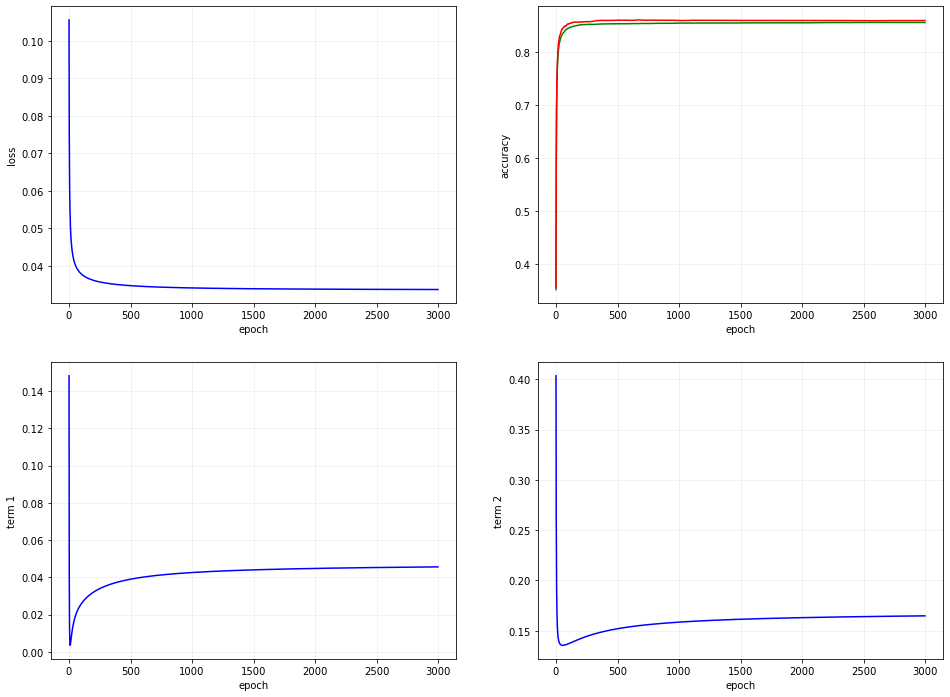

In [8]:
fig, axs = plt.subplots(2, 2, figsize = (16, 12))

axs[0][0].plot(loss_tab, color='blue')
axs[0][1].plot(train_accuracy_tab, color='green')
axs[0][1].plot(test_accuracy_tab, color='red')

axs[1][0].plot(term_I_tab, color = 'blue')
axs[1][1].plot(term_II_tab, color = 'blue')

for row in axs:
    for ax in row:
        ax.grid(True, alpha =0.2)
        ax.set_xlabel('epoch')
        #ax.set_yscale('log')

axs[0][0].set_ylabel('loss')
axs[0][1].set_ylabel('accuracy')
axs[1][0].set_ylabel('term 1')
axs[1][1].set_ylabel('term 2')
plt.show()



In [14]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(255/256, 1, N)    ## red  255,192, 203
vals[:, 1] = np.linspace(192/256, 1, N)
vals[:, 2] = np.linspace(203/256, 1, N)  ## blue 75, 0, 130
Pinks = ListedColormap(vals)


top = cm.get_cmap(Pinks, 256)
bottom = cm.get_cmap('Purples', 256)

newcolors = np.vstack((top(np.linspace(0, 1, 256)),
                       bottom(np.linspace(0, 1, 256))))

newcmp = ListedColormap(newcolors, name='PinkPueple')

In [15]:
params=[]
for param in model.parameters():
    params.append(param.detach().numpy())
w1=params[0] 
w2=params[1]


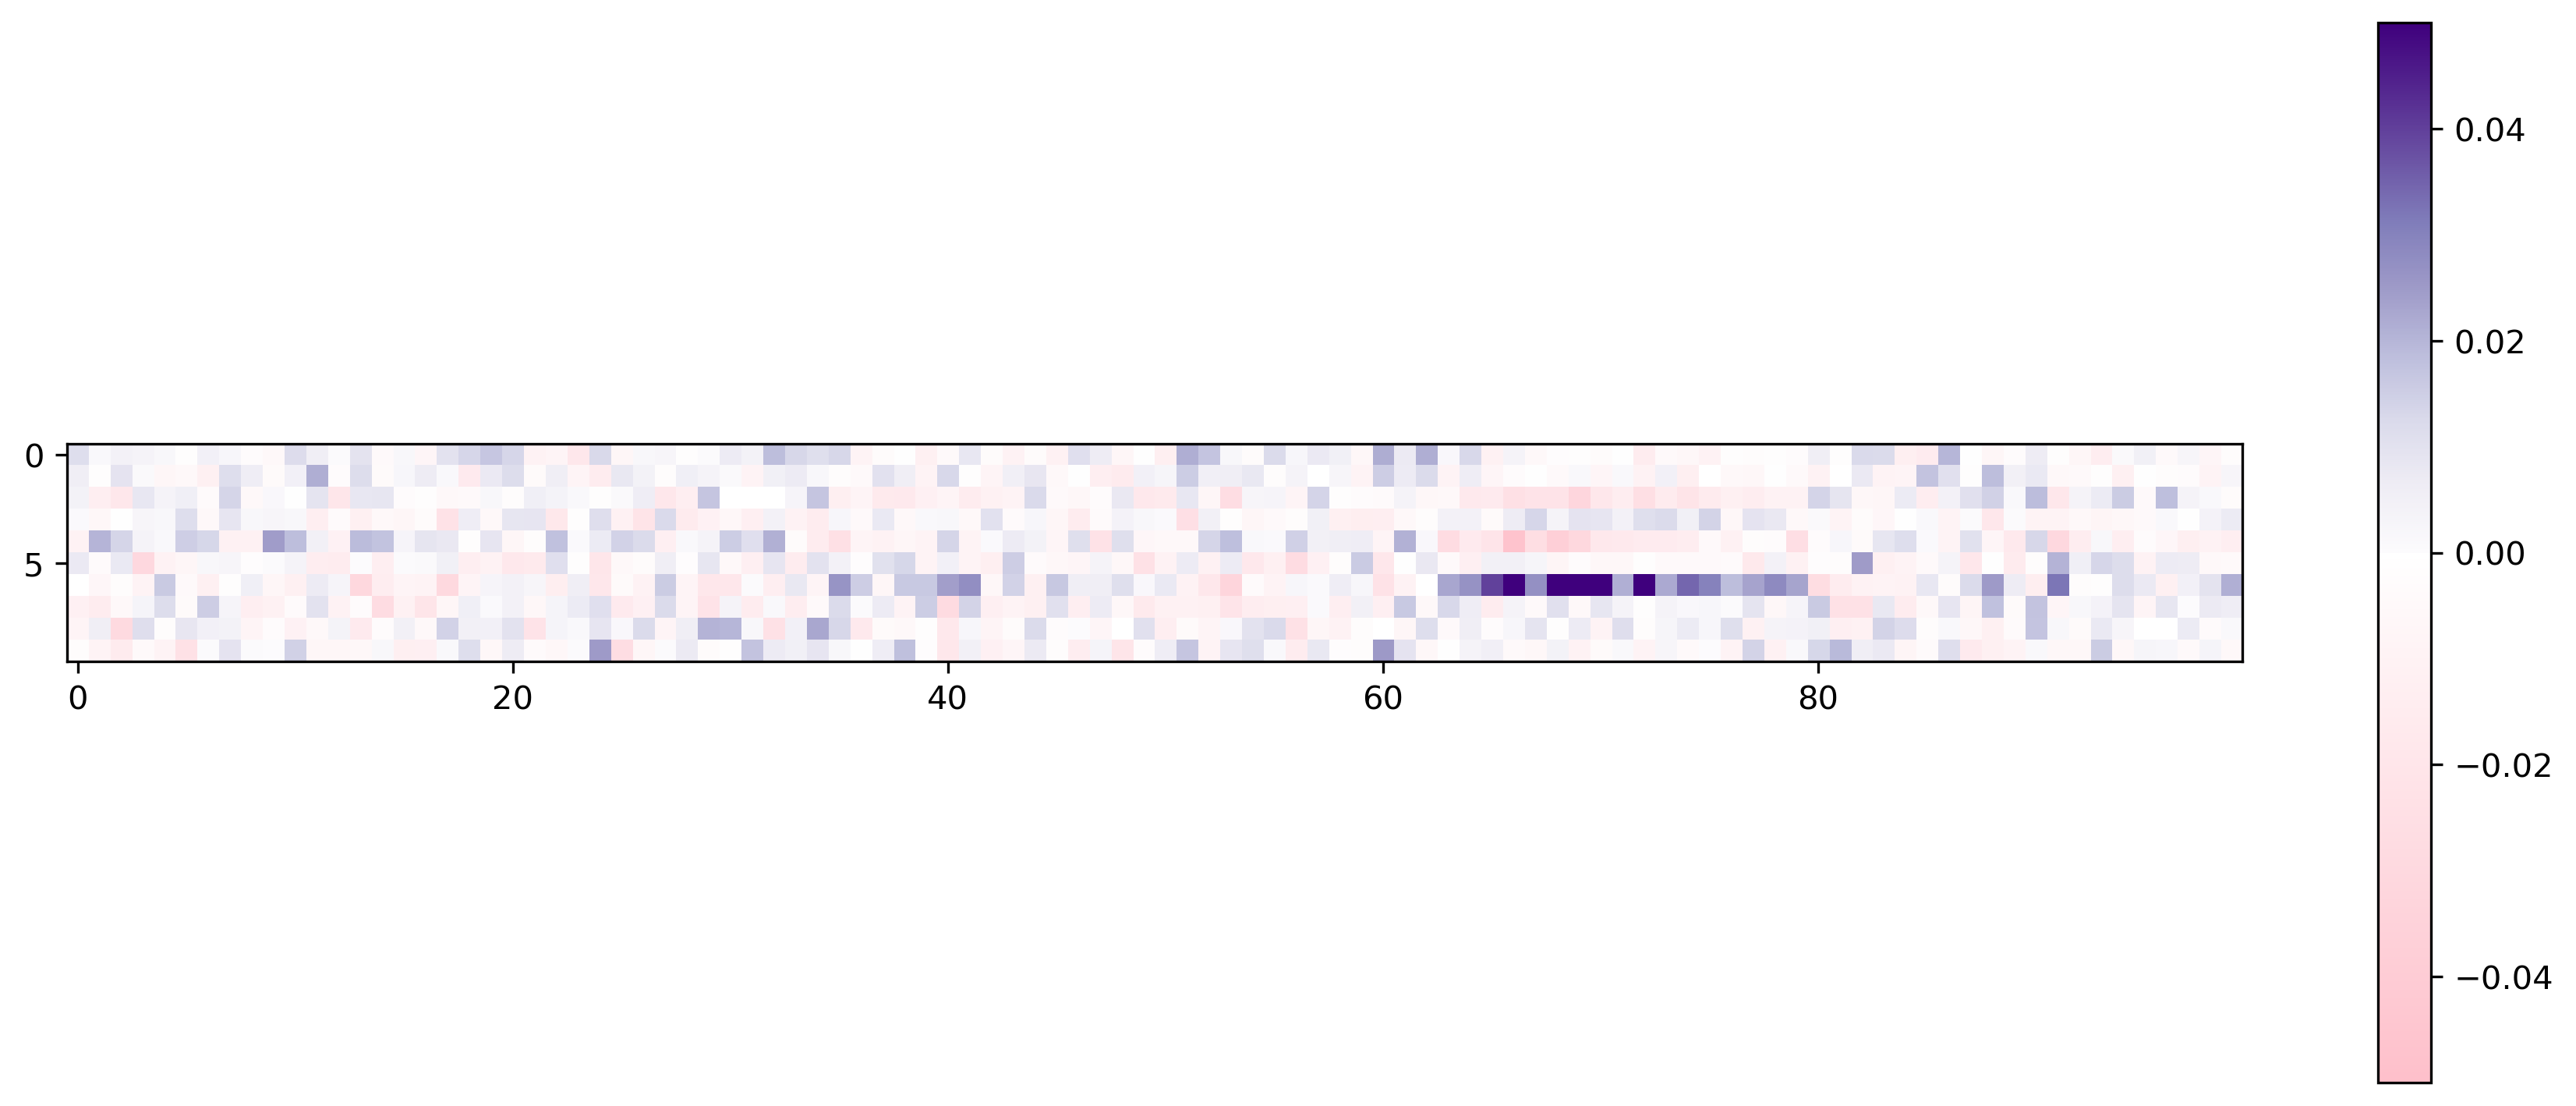

In [16]:
from matplotlib.pyplot import figure
figure(figsize=(15, 6), dpi=300)

WW =  w2 @ w1 
plt.imshow( WW[:100,:100], cmap = newcmp, vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.show()


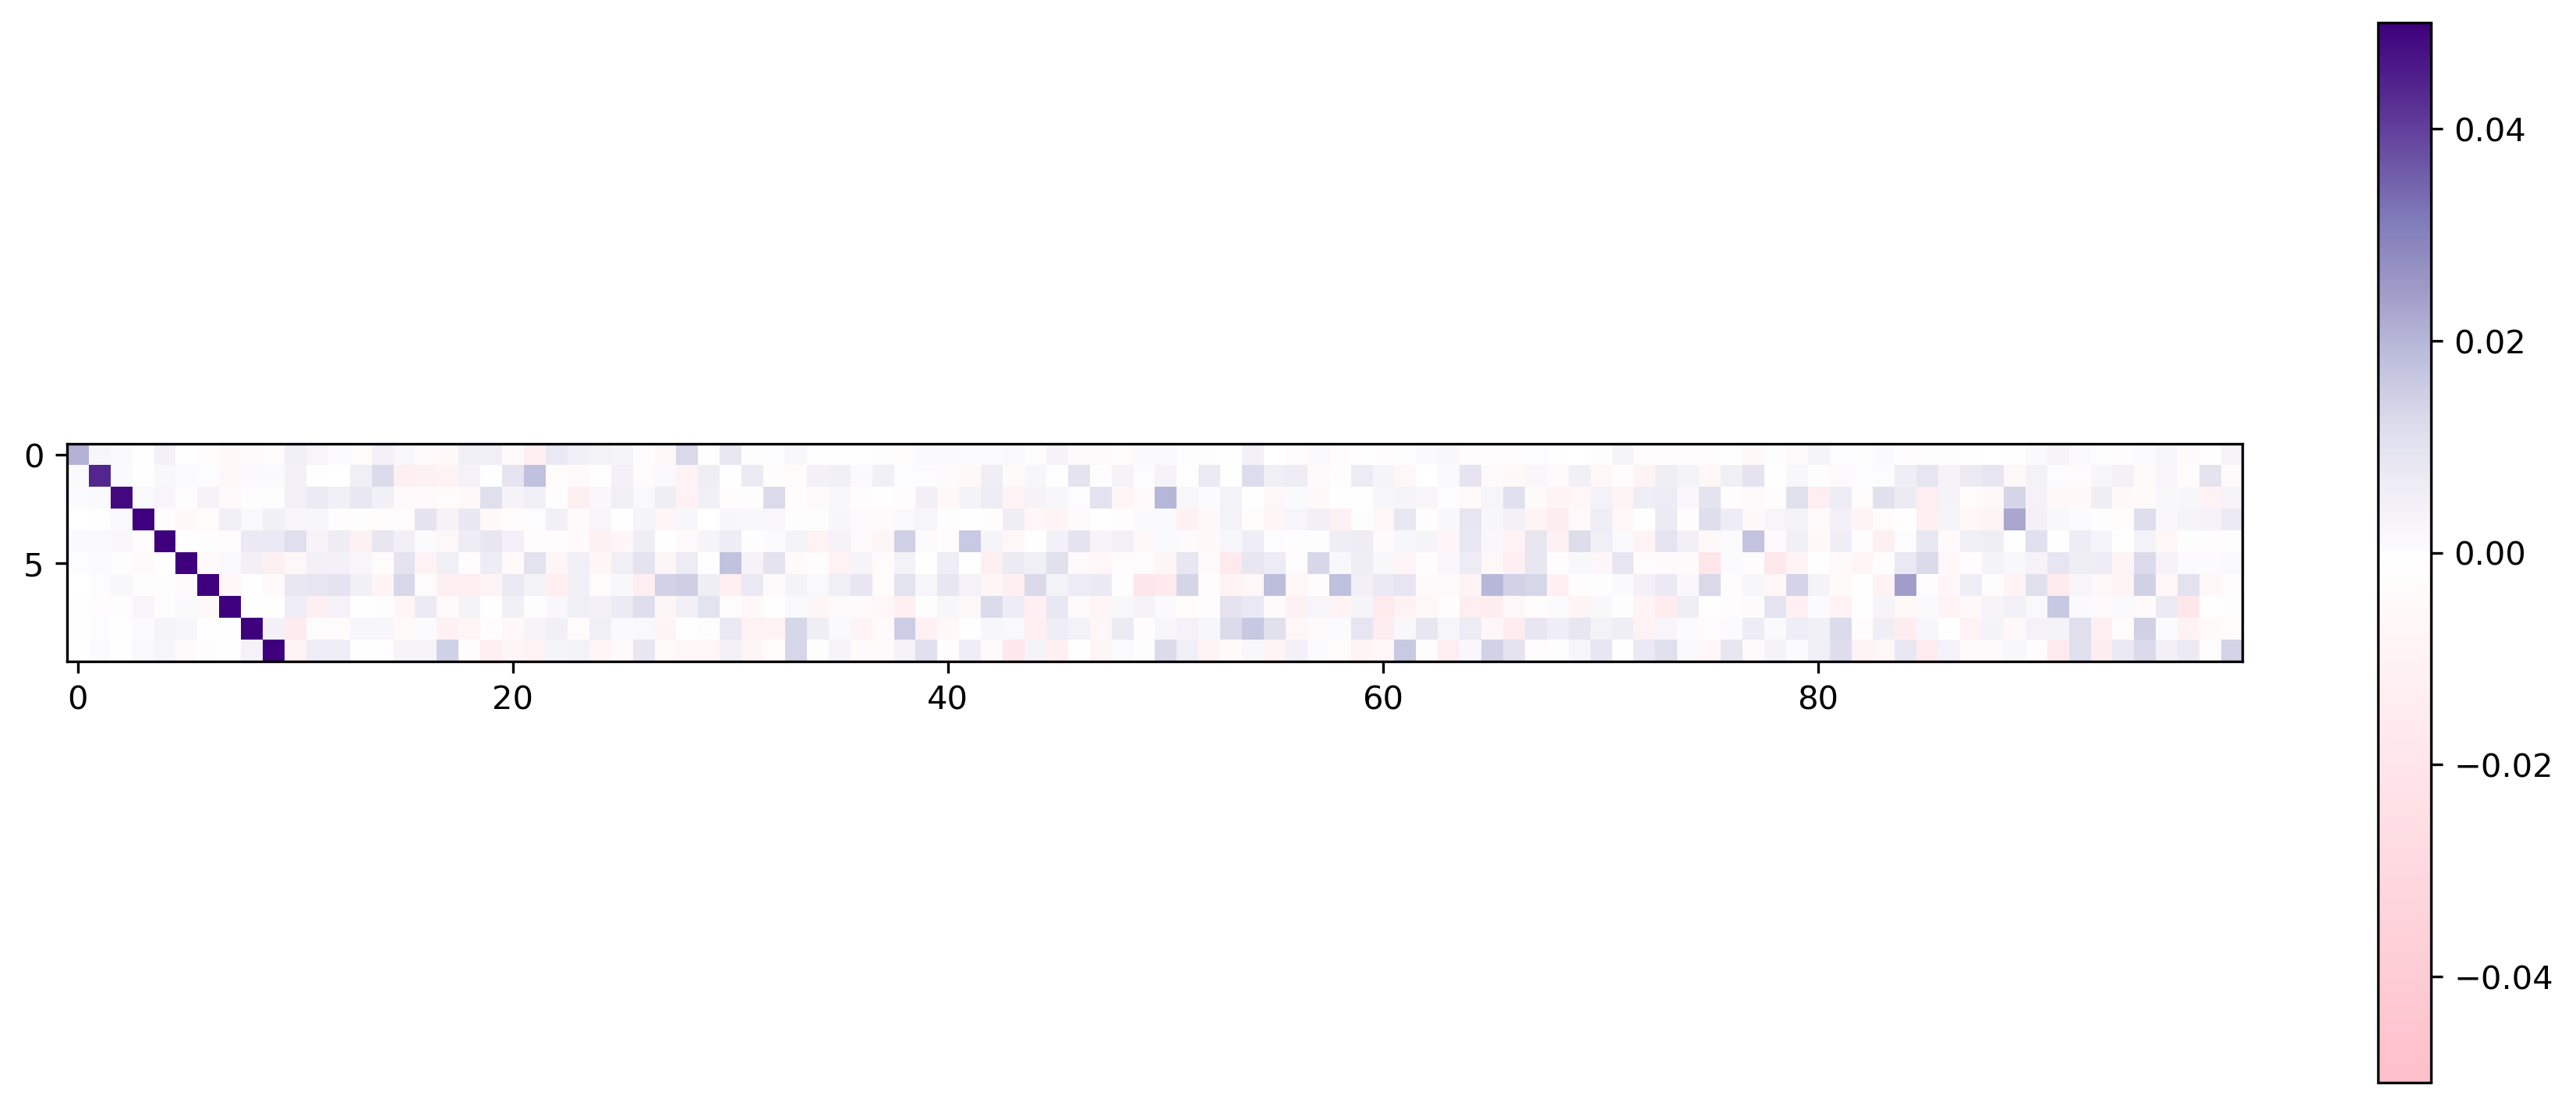

In [17]:
from matplotlib.pyplot import figure
figure(figsize=(15, 6), dpi=300)

WW = U_matrix.T @ w2 @ w1 @ V_matrix
plt.imshow( WW[:100,:100], cmap = newcmp, vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.show()


CHECK: $$MSE = \frac{1}{P} \sum_{\mu=1}^P \lVert y-\hat{y} \rVert ^2 $$
$$ MSE= \frac{1}{P} \sum_{\mu=1}^P \lVert y - W^2 W^1 x \rVert ^2 $$ 

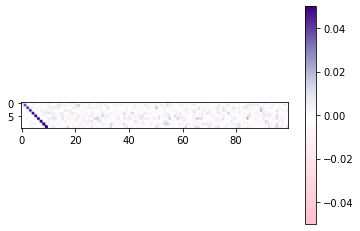

In [18]:
R = U_matrix.T @ w2 @ w1 @ V_matrix
plt.imshow( R[:, :100], cmap = newcmp, vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.show()

## Calculation of terms

In [19]:
term_1 = 0
for alpha in range(10):
    term_1 += (R[alpha][alpha] - S31_matrix[alpha]/S11_matrix[alpha][alpha])**2 * S11_matrix[alpha][alpha]
term_1



array([0.04559343])

In [20]:
term_2 = 0
for beta in range(10):
    for alpha in range(784):
        if(alpha != beta):
            term_2 += (R[beta][alpha])**2 *S11_matrix[alpha][alpha]
term_2


0.16483384095580808

In [21]:
term_3 = np.trace(S33_matrix)
term_3

1.000000009

In [22]:
term_4 = 0
for alpha in range(10):
    term_4+= (S31_matrix[alpha])**2/S11_matrix[alpha][alpha]
term_4   

array([0.49717632])

In [23]:
term_1+term_2+term_3-term_4

array([0.71325097])

In [24]:
term_3-term_4

array([0.50282369])

## terms with star: $T_1^*$,  $T_2^*$,  $T_4^*$

In [25]:
term_4 = 0
for alpha in range(10):
    term_4+= (R[alpha][alpha])**2*S11_matrix[alpha][alpha]
term_4   

0.7831035848172166

In [26]:
term_3-term_4

0.21689642418278343

In [27]:
term_2+term_3-term_4

0.38173026513859154

In [28]:
term_1+term_2+term_3-term_4

array([0.4273237])

# Final MSE on training / testing dataset


In [29]:
MSE_tab=[]
SE_model_tab=[]
SE_calc_tab=[]

batch_size: int = 1  
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [30]:
with torch.no_grad():
    for i, (x,y) in enumerate(train_loader):
        
        y=F.one_hot(y, num_classes=10).float()
        y_model = model(x)
        
        MSE = criterion(y_model, y)
        SE_model = np.linalg.norm(y_model - y)**2
        
        x=x.detach().numpy().flatten()
        y=y.detach().numpy().flatten()
        
        y_calc = w2 @ w1 @ x
        SE_calc = np.linalg.norm(y_calc - y)**2

        MSE_tab.append(float(MSE))
        SE_model_tab.append(float(SE_model))
        SE_calc_tab.append(float(SE_calc))

        #print(i,"\tMSE = {:.6f} \tSE_model = {:.6f}\tSEcalc = {:.6f}".format(MSE, SE_model, SE_calc))
        
mean_MSE = sum(MSE_tab)/len(MSE_tab)
mean_SE_model = sum(SE_model_tab)/len(SE_model_tab)
mean_SE_calc = sum(SE_calc_tab)/len(SE_calc_tab)

print("Mean square error evaluated on training set")
print("MSE = {:.6f} \tMSE_model = {:.6f}\tMSEcalc = {:.6f}".format(mean_MSE, mean_SE_model, mean_SE_calc))

Mean square error evaluated on training set
MSE = 0.038281 	MSE_model = 0.382814	MSEcalc = 0.382814


In [31]:
with torch.no_grad():
    for i, (x,y) in enumerate(test_loader):
        
        y=F.one_hot(y, num_classes=10).float()
        y_model = model(x)
        
        MSE = criterion(y_model, y)
        SE_model = np.linalg.norm(y_model - y)**2
        
        x=x.detach().numpy().flatten()
        y=y.detach().numpy().flatten()
        
        y_calc =  w2 @ w1 @ x
        SE_calc = np.linalg.norm(y_calc - y)**2

        MSE_tab.append(float(MSE))
        SE_model_tab.append(float(SE_model))
        SE_calc_tab.append(float(SE_calc))

        #print(i,"\tMSE = {:.6f} \tSE_model = {:.6f}\tSEcalc = {:.6f}".format(MSE, SE_model, SE_calc))
        
mean_MSE = sum(MSE_tab)/len(MSE_tab)
mean_SE_model = sum(SE_model_tab)/len(SE_model_tab)
mean_SE_calc = sum(SE_calc_tab)/len(SE_calc_tab)

print("Mean square error evaluated on test set")
print("MSE = {:.6f} \tMSE_model = {:.6f}\tMSEcalc = {:.6f}".format(mean_MSE, mean_SE_model, mean_SE_calc))

Mean square error evaluated on test set
MSE = 0.038283 	MSE_model = 0.382828	MSEcalc = 0.382828


# Save All

In [35]:
import pandas as pd

savefile = 'ground_energy_300.csv'
df = pd.DataFrame()

df['loss'] = loss_tab
df['train_accuracy'] = train_accuracy_tab
df['test_accuracy'] = test_accuracy_tab

df['w1_mean'] = w1_mean_tab
df['w1_std'] = w1_std_tab
df['w2_mean'] = w2_mean_tab
df['w2_std'] = w2_std_tab


df['term_I'] = term_I_tab
df['term_II'] = term_II_tab
df['term_IV'] = term_IV_tab
df['R'] = R_tab


df.to_csv(savefile, index=False)

df_w2= pd.DataFrame(np.array(w2_tab).T)
df_w3= pd.DataFrame(np.array(w3_tab).T)

df_w2.to_csv('ground_energy_300_w2.csv', index=False)
df_w3.to_csv('ground_energy_300_w3.csv', index=False)


In [36]:
w1=deepcopy(model.parameters()[0]).detach().numpy().reshape(input_dim*hidden_dim1)
w2=deepcopy(model.parameters()[1]).detach().numpy().reshape(hidden_dim1*output_dim)

df_w1 = pd.DataFrame(w1, columns = ['w1'] )
df_w2 = pd.DataFrame(w2, columns = ['w2'] )

df_w1.to_csv('w1.csv', index=False)
df_w2.to_csv('w2.csv', index=False)
